In [2]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [3]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import time

from data.tinyimagenet import TinyImageNet

from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps
from our_modules.eval_tools import max_logit_change_compared_id_vs_ood

from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image
from our_modules.plot_tools import plot_image_on_ax

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import get_model_for_split
from our_modules.tin_tools import transform_range as tin_transform_range

from our_modules.adv_tools import fn_osr_fgsm, fp_osr_fgsm, fn_osr_fgsm_log_msp



### Setting the Device

In [5]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


# Tinyimagenet

In [6]:
tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
tin_goldfish = tin_dataset[9][0]

### Class for plotting eps experiments

In [7]:
class eps_experiment_plot():
    def __init__(self, eps_figsize=(10,4), adv_figsize=(15,6), which_lines='both', add_zoom=(-0.003, 0.012, 0.825, 0.84)):
        self.which_lines = which_lines
        self.add_zoom = add_zoom

        eps_fig, eps_ax = plt.subplots(1,1, figsize=eps_figsize)
        self.fig = eps_fig
        self.ax1 = eps_ax
        self.ax1.set_xlabel('$\\epsilon$ - the size of the advesarial perturbation.')
        self.ax1.set_ylabel('AUROC', c='black')

        if self.add_zoom:
            self.axins = zoomed_inset_axes(self.ax1, 10, loc=1)

        if self.which_lines == 'both':
            self.ax1.set_xlabel('$\\epsilon$ - the size of the advesarial perturbation.')
            self.ax1.set_ylabel('AUROC', c='red')
            self.ax2 = eps_ax.twinx()
            self.ax2.set_ylabel('Average OSR Score - $\\mathcal{S}\\:(y\\in\\mathcal{C}\\mid x)$', c='blue')
        if self.which_lines == 'mls':
            self.ax2 = self.ax1
            self.ax2.set_ylabel('Average OSR Score - $\\mathcal{S}\\:(y\\in\\mathcal{C}\\mid x)$', c='black')
        self.recent_eps = None


    def load_and_add_to_eps_plot(self, path_to_eps_dirs, split_num, balance=True, label_suffix='', **plt_kwargs):
        eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(path_to_eps_dirs, split_num, dataset_name='tinyimagenet', balance=balance, return_avg_mls=True)
        aurocs = [x[1] for x in roc_stats]
        self.recent_eps = eps

        if self.which_lines == 'both':
            self.ax1.plot(eps, aurocs, c='red', label='AUROC' + label_suffix)
            # self.ax1.scatter(eps, aurocs, c='red', marker='.')
            if self.add_zoom:
                self.axins.plot(eps, aurocs, c='red')
            
            self.ax2.plot(eps, avg_mls, c='blue', label='Average OSR Score' + label_suffix)
            # self.ax2.scatter(eps, avg_mls, c='blue', marker='.')
            if self.add_zoom:
                self.axins.plot(eps, avg_mls, c='blue')

        if self.which_lines == 'AUROC':
            self.ax1.plot(eps, aurocs, label='AUROC' + label_suffix, **plt_kwargs)
            # self.ax1.scatter(eps, aurocs, c='red', marker='.')
            if self.add_zoom:
                self.axins.plot(eps, aurocs, **plt_kwargs)
        
        if self.which_lines == 'mls':
            self.ax2.plot(eps, avg_mls, label='Average OSR Score' + label_suffix, **plt_kwargs)
            # self.ax2.scatter(eps, avg_mls, c='blue', marker='.')
            if self.add_zoom:
                self.axins.plot(eps, aurocs, **plt_kwargs)
        if self.add_zoom:
            self.axins.set_xlim(self.add_zoom[0], self.add_zoom[1])
            self.axins.set_ylim(self.add_zoom[2], self.add_zoom[3])
            mark_inset(self.ax1, self.axins, loc1=2, loc2=3, fc="none", ec="0.5")

    def set_legend_and_highlight_eps(self, eps_idxs=[], legend_loc=(0.72,0.8)):
        for i in eps_idxs:
            self.ax1.axvline(round(self.recent_eps[i],2), 0, 1, linestyle='dashed', c='gray', alpha=0.5,)
            if self.add_zoom:
                self.axins.axvline(self.recent_eps[i], 0, 1, linestyle='dashed', c='gray', alpha=0.5,)
        chosen_eps = [self.recent_eps[i] for i in eps_idxs]
        locs, labels = plt.xticks()
        locs = locs[1:-1]
        locs = [l for l in locs if not np.isclose(l, chosen_eps, rtol=0.0, atol=0.05).any()]
        locs += chosen_eps
        plt.xticks([round(l, 2) for l in locs])
        self.fig.legend(loc=legend_loc)

    def show_and_save(self, save_as=False):
        plt.show()
        if save_as:
            plt.savefig(root_dir + 'visualizations/'+ save_as + '.png', transparent=True, bbox_inches='tight')
        

# axins = zoomed_inset_axes(ax1, 10, loc=1) # zoom = 2
        # axins.plot(eps, aurocs, c='red')
        # axins.scatter(eps, aurocs, c='red', marker='.')
        # axins.set_xlim(-0.01, 0.012)
        # axins.set_ylim(0.825, 0.84)
        # plt.xticks(visible=False)
        # plt.yticks(visible=False)
        # mark_inset(ax1, axins, loc1=2, loc2=3, fc="none", ec="0.5")
        # plt.draw()
        
        

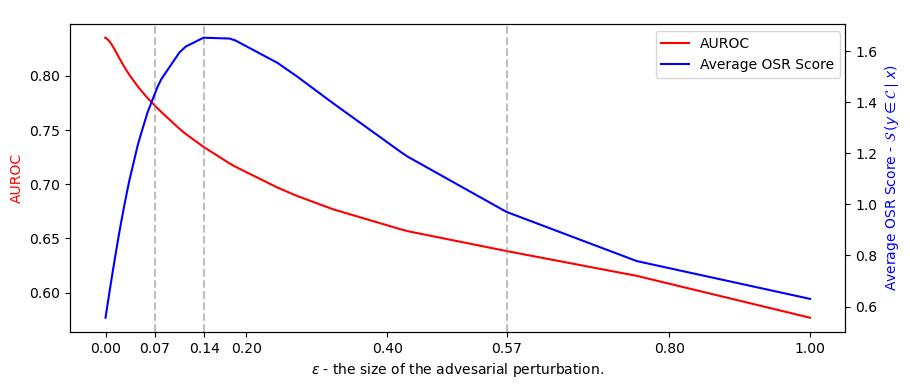

In [8]:
eps_exp_1 = eps_experiment_plot(which_lines='both', add_zoom=False)
eps_exp_1.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True)
eps_exp_1.set_legend_and_highlight_eps([-15, -11, -3], legend_loc=(0.72, 0.8))
eps_exp_1.show_and_save()

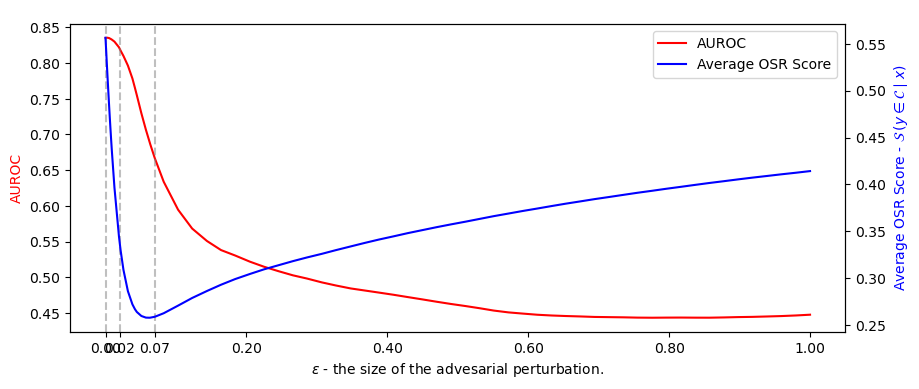

In [9]:
eps_exp_2 = eps_experiment_plot(add_zoom=False)
eps_exp_2.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True)
eps_exp_2.set_legend_and_highlight_eps([3, 15, 25], legend_loc=(0.71,0.8))
eps_exp_2.show_and_save()

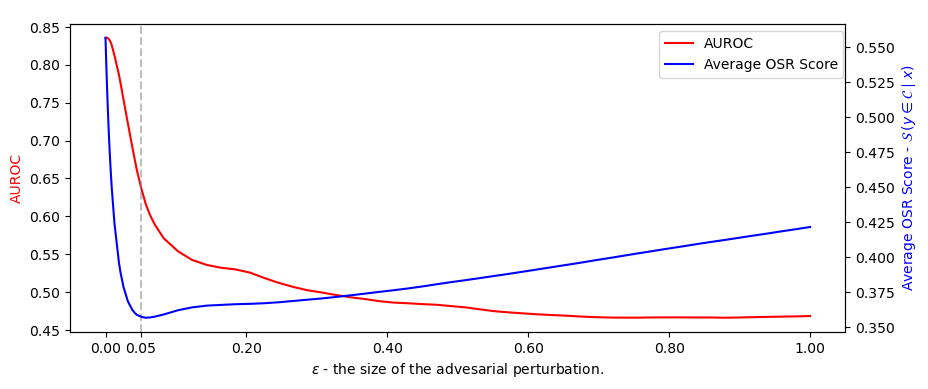

In [10]:
eps_exp_3 = eps_experiment_plot(add_zoom=False)
eps_exp_3.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True)
eps_exp_3.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_3.show_and_save()

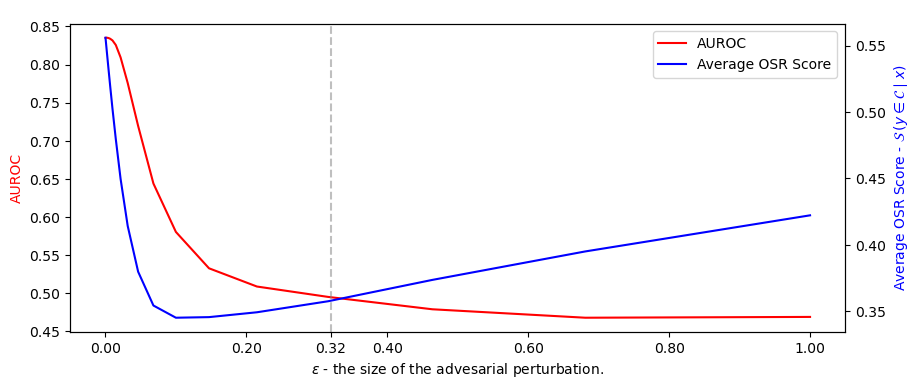

In [11]:
eps_exp_4 = eps_experiment_plot(add_zoom=False)
eps_exp_4.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True)
eps_exp_4.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_4.show_and_save()

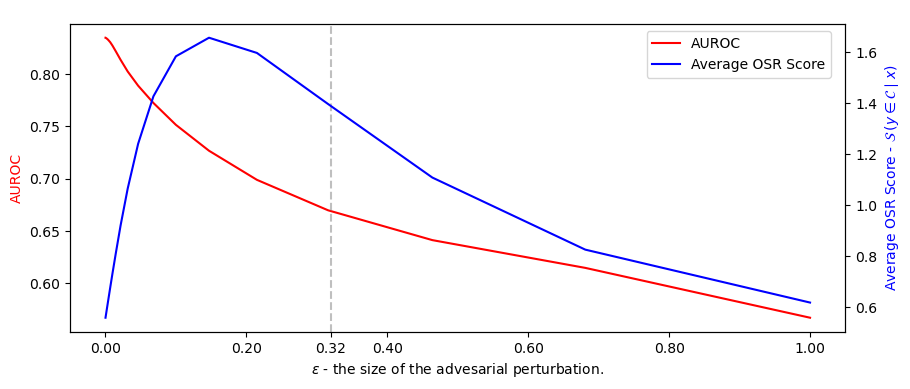

In [12]:
eps_exp_4 = eps_experiment_plot(add_zoom=False)
eps_exp_4.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True)
eps_exp_4.set_legend_and_highlight_eps([21], legend_loc=(0.71,0.8))
eps_exp_4.show_and_save()

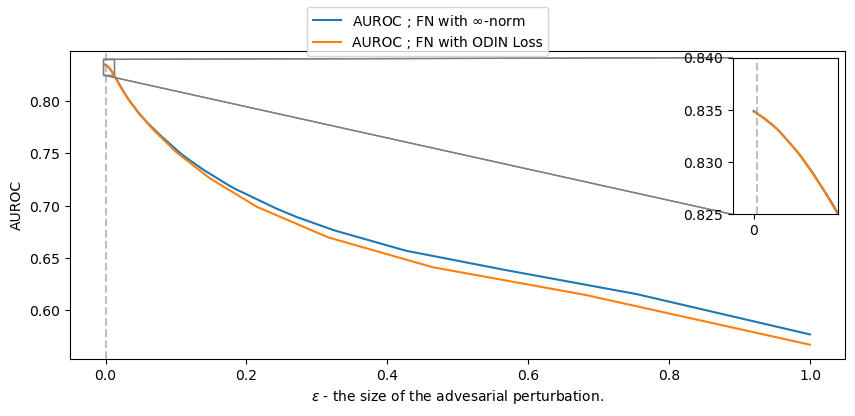

In [34]:
comparison_exp = eps_experiment_plot(which_lines='AUROC')
comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
# comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
# comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
# comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp.set_legend_and_highlight_eps(legend_loc='upper center', eps_idxs = [4])


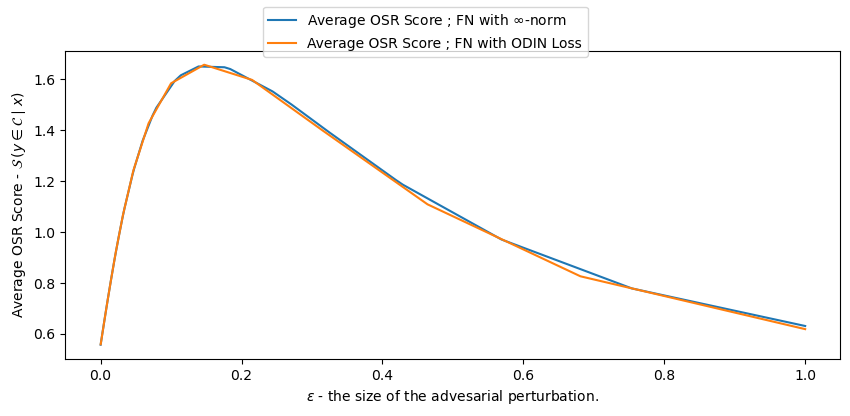

In [35]:
comparison_exp = eps_experiment_plot(which_lines='mls', add_zoom=False)
comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, True, label_suffix=' ; FN with $\\infty$-norm')
comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss')
# comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm')
# comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, True, label_suffix= ' ; FP with $\\infty$-norm')
# comparison_exp.load_and_add_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss')
comparison_exp.set_legend_and_highlight_eps(legend_loc='upper center')

### FN

#### FGSM with varying epsilon values

In [15]:
eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fn/fgsm/inf_norm/', 0, dataset_name='tinyimagenet', balance=True, return_avg_mls=True)
aurocs = [x[1] for x in roc_stats]

In [16]:
fn_goldfish_eps_zip_steps_0 = [fn_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True)
                          for ep in eps]
fn_goldfish_eps_0, fn_goldfish_eps_steps_0 = [x for x, _ in fn_goldfish_eps_zip_steps_0], [x for _, x in fn_goldfish_eps_zip_steps_0]

/Users/gunder/Desktop/bachelor_project/our_modules/adv_tools.py:34: UserWarning: The operator 'aten::linalg_vector_norm' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return fgsm(model, x, torch.zeros(len(x)), eps, lambda y_hat, y: torch.linalg.norm(y_hat, dim=-1, ord=norm_ord),


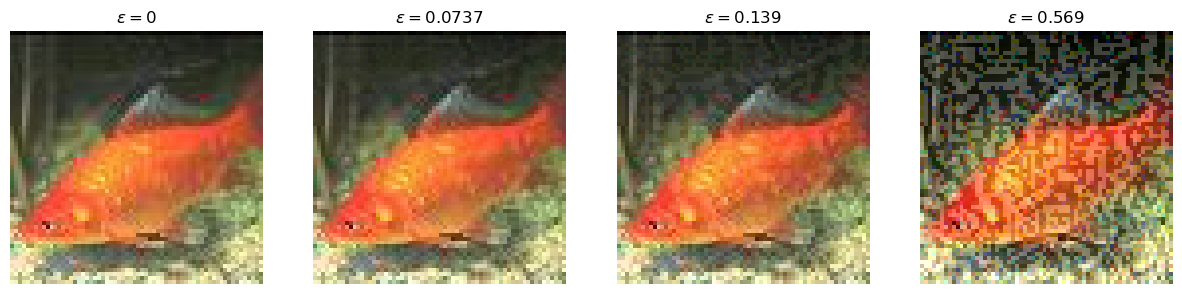

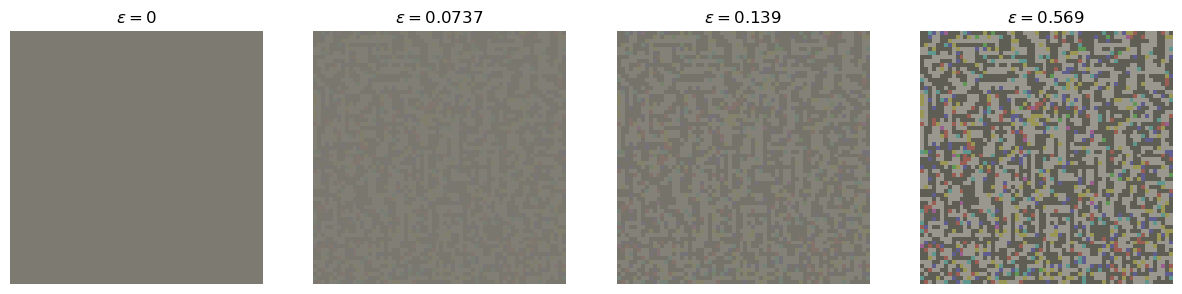

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
# eps_idxs = [-24, -11, -1]
eps_idxs = [-15, -11, -3]
chosen_eps = [eps[i] for i in eps_idxs]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fn_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
plt.savefig(root_dir + 'visualizations/goldfish_fn_fgsm.png', transparent=True, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fn_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
plt.savefig(root_dir + 'visualizations/goldfish_fn_fgsm_pertubation.png', transparent=True, bbox_inches='tight')
plt.show()
# plot_image(fn_goldfish_eps_steps_0[9][0], mean=tin_mean, std=tin_std)
# plot_image(fn_goldfish_eps_steps_0[44][0], mean=tin_mean, std=tin_std)
# plot_image(fn_goldfish_eps_steps_0[-1][0], mean=tin_mean, std=tin_std)


In [18]:
# fig, ax1 = plt.subplots(1,1, figsize=(10,4))
# ax1.plot(eps, aurocs, c='red', label='AUROC')
# ax1.scatter(eps, aurocs, c='red', marker='.')
# ax1.set_xlabel('$\\epsilon$ - the size of the advesarial perturbation.')
# ax1.set_ylabel('AUROC', c='red')
# for i in eps_idxs:
#     ax1.axvline(eps[i], 0, 1, linestyle='dashed', c='gray', alpha=0.5,)
# ax2 = ax1.twinx()
# ax2.plot(eps, avg_mls, c='blue', label='Average OSR Score')
# ax2.scatter(eps, avg_mls, c='blue', marker='.')
# ax2.set_ylabel('Average OSR Score - $\\mathcal{S}\\:(y\\in\\mathcal{C}\\mid x)$', c='blue')
# locs, labels = plt.xticks()
# plt.xticks([round(x,2) for x in np.append(locs[1:-1][~np.isclose(locs[1:-1], 0.6)], chosen_eps)])
# fig.legend(loc=(0.72,0.8))
# plt.savefig(root_dir + 'visualizations/fn_fgsm_eps.png', transparent=True, bbox_inches='tight')
# plt.show()


In [19]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet', balance=True)
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_fn = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0622/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0622/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)

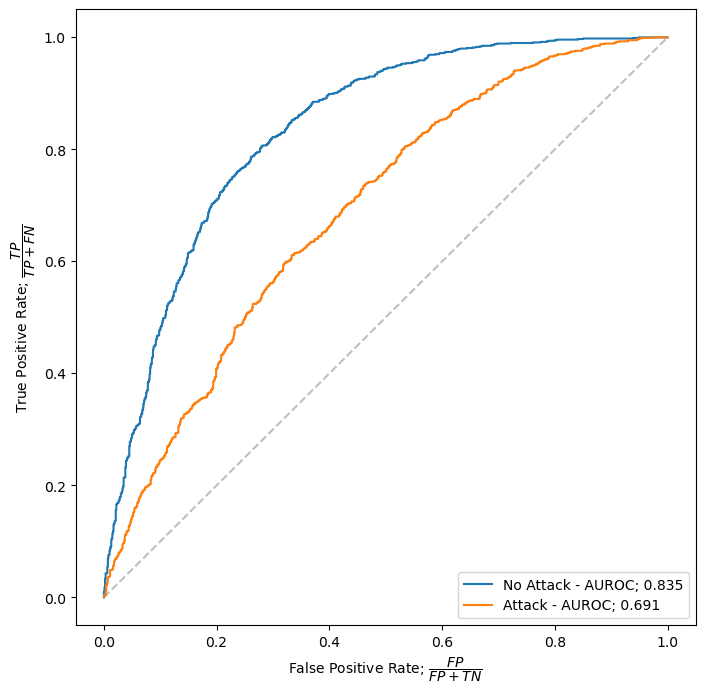

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_fn[0], label=f'Attack - AUROC; {roc_stats_fn[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='lower right')
plt.show()

In [21]:
id_diffs, ood_diffs = max_logit_change_compared_id_vs_ood(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                          root_dir + "logits/tinyimagenet/fp/fgsm/inf_norm/eps_0.511/logits_0.pt",
                                                          root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                          0, dataset_name='tinyimagenet')

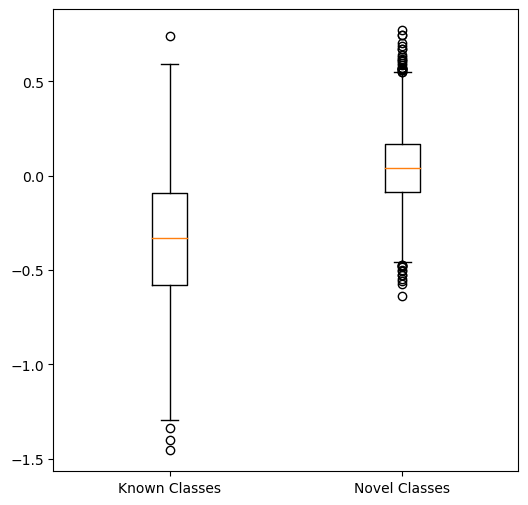

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.boxplot([id_diffs, ood_diffs[:1000]], labels=['Known Classes', 'Novel Classes'])
plt.show()

### FP

#### Two norm

In [23]:
eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, dataset_name='tinyimagenet', balance=True, return_avg_mls=True)
aurocs = [x[1] for x in roc_stats]

In [24]:
fp_two_goldfish_eps_zip_steps_0 = [fp_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True, norm_ord=None)
                          for ep in eps]
fp_two_goldfish_eps_0, fp_two_goldfish_eps_steps_0 = [x for x, _ in fp_two_goldfish_eps_zip_steps_0], [x for _, x in fp_two_goldfish_eps_zip_steps_0]

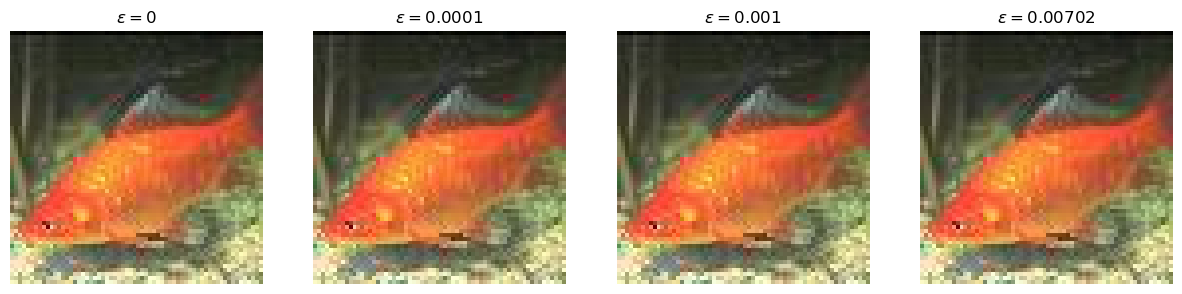

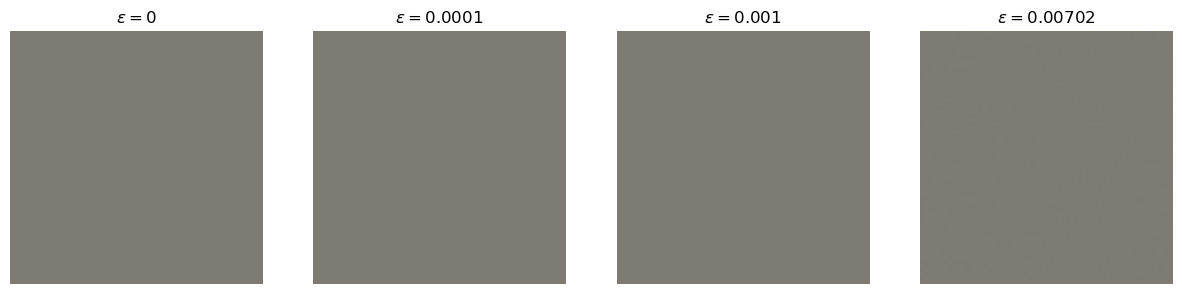

In [25]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
# eps_idxs = [-24, -11, -1]
eps_idxs = [1, 2, 10]
chosen_eps = [eps[i] for i in eps_idxs]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_two_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_two_fgsm.png', transparent=True, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_two_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_two_fgsm_pertubation.png', transparent=True, bbox_inches='tight')
plt.show()

In [26]:
# fig, ax1 = plt.subplots(1,1, figsize=(10,4))
# ax1.plot(eps, aurocs, c='red', label='AUROC')
# ax1.scatter(eps, aurocs, c='red', marker='.')
# ax1.set_xlabel('$\\epsilon$ - the size of the advesarial perturbation.')
# ax1.set_ylabel('AUROC', c='red')
# for i in eps_idxs:
#     ax1.axvline(eps[i], 0, 1, linestyle='dashed', c='gray', alpha=0.5,)
# ax2 = ax1.twinx()
# ax2.plot(eps, avg_mls, c='blue', label='Average OSR Score')
# ax2.scatter(eps, avg_mls, c='blue', marker='.')
# ax2.set_ylabel('Average OSR Score - $\\mathcal{S}\\:(y\\in\\mathcal{C}\\mid x)$', c='blue')
# # axins = zoomed_inset_axes(ax1, 10, loc=1) # zoom = 2
# # axins.plot(eps, aurocs, c='red')
# # axins.scatter(eps, aurocs, c='red', marker='.')
# # axins.set_xlim(-0.01, 0.012)
# # axins.set_ylim(0.825, 0.84)
# # plt.xticks(visible=False)
# # plt.yticks(visible=False)
# # mark_inset(ax1, axins, loc1=2, loc2=3, fc="none", ec="0.5")
# # plt.draw()
# locs, labels = plt.xticks()
# plt.xticks([round(x,2) for x in np.append(locs[1:-1][~np.isclose(locs[1:-1], 0.6)], chosen_eps)])
# fig.legend(loc=(0.72,0.8))
# # plt.savefig(root_dir + 'visualizations/fp_two_fgsm_eps.png', transparent=True, bbox_inches='tight')
# plt.show()

#### Infinity norm

In [27]:
eps, roc_stats, avg_mls = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fp/fgsm/inf_norm/', 0, dataset_name='tinyimagenet', balance=True, return_avg_mls=True)
aurocs = [x[1] for x in roc_stats]

In [28]:
fp_inf_goldfish_eps_zip_steps_0 = [fp_osr_fgsm(get_model_for_split(split_num=0, path_to_pretrained_weights_folder=root_dir + 'pretrained_weights/', device=device),
                                                tin_goldfish.to(device).detach()[None], ep, clip_range=tin_transform_range, return_step=True, norm_ord=torch.inf)
                          for ep in eps]
fp_inf_goldfish_eps_0, fp_inf_goldfish_eps_steps_0 = [x for x, _ in fp_inf_goldfish_eps_zip_steps_0], [x for _, x in fp_inf_goldfish_eps_zip_steps_0]

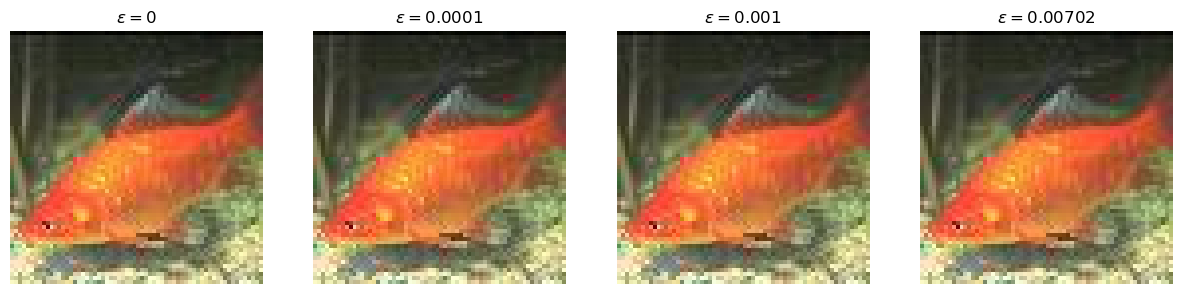

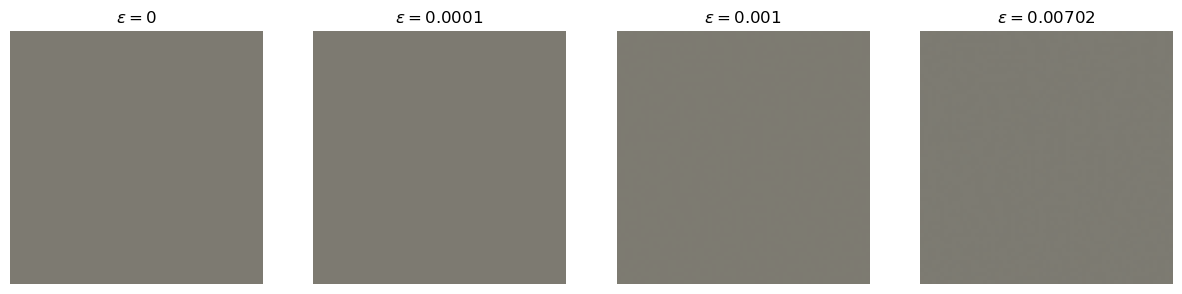

In [29]:
fig, ax = plt.subplots(1, 4, figsize = (15, 6))
# eps_idxs = [-24, -11, -1]
eps_idxs = [1, 2, 10]
chosen_eps = [eps[i] for i in eps_idxs]
plot_image_on_ax(ax[0], tin_goldfish, mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_inf_goldfish_eps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_inf_fgsm.png', transparent=True, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 4, figsize = (15, 6))
plot_image_on_ax(ax[0], torch.zeros_like(tin_goldfish), mean=tin_mean, std=tin_std)
ax[0].set_title(f"$\\epsilon = 0$")
ax[0].axis('off')
for i, idx in enumerate(eps_idxs):
    plot_image_on_ax(ax[i+1], fp_inf_goldfish_eps_steps_0[idx][0], mean=tin_mean, std=tin_std)
    ax[i+1].set_title(f"$\\epsilon = {eps[idx]:.3}$")
    ax[i+1].axis('off')
# plt.savefig(root_dir + 'visualizations/goldfish_fp_inf_fgsm_pertubation.png', transparent=True, bbox_inches='tight')
plt.show()

In [30]:
# fig, ax1 = plt.subplots(1,1, figsize=(10,4))
# ax1.plot(eps, aurocs, c='red', label='AUROC')
# ax1.scatter(eps, aurocs, c='red', marker='.')
# ax1.set_xlabel('$\\epsilon$ - the size of the advesarial perturbation.')
# ax1.set_ylabel('AUROC', c='red')
# for i in eps_idxs:
#     ax1.axvline(eps[i], 0, 1, linestyle='dashed', c='gray', alpha=0.5,)
# ax2 = ax1.twinx()
# ax2.plot(eps, avg_mls, c='blue', label='Average OSR Score')
# ax2.scatter(eps, avg_mls, c='blue', marker='.')
# ax2.set_ylabel('Average OSR Score - $\\mathcal{S}\\:(y\\in\\mathcal{C}\\mid x)$', c='blue')
# # axins = zoomed_inset_axes(ax1, 10, loc=1) # zoom = 2
# # axins.plot(eps, aurocs, c='red')
# # axins.scatter(eps, aurocs, c='red', marker='.')
# # axins.set_xlim(-0.01, 0.012)
# # axins.set_ylim(0.825, 0.84)
# # plt.xticks(visible=False)
# # plt.yticks(visible=False)
# # mark_inset(ax1, axins, loc1=2, loc2=3, fc="none", ec="0.5")
# # plt.draw()
# locs, labels = plt.xticks()
# plt.xticks([round(x,2) for x in np.append(locs[1:-1][~np.isclose(locs[1:-1], 0.6)], chosen_eps)])
# fig.legend(loc=(0.72,0.8))
# # plt.savefig(root_dir + 'visualizations/fp_inf_fgsm_eps.png', transparent=True, bbox_inches='tight')
# plt.show()

In [31]:
## TO ZOOM
# axins = zoomed_inset_axes(ax1, 10, loc=1) # zoom = 2
        # axins.plot(eps, aurocs, c='red')
        # axins.scatter(eps, aurocs, c='red', marker='.')
        # axins.set_xlim(-0.01, 0.012)
        # axins.set_ylim(0.825, 0.84)
        # plt.xticks(visible=False)
        # plt.yticks(visible=False)
        # mark_inset(ax1, axins, loc1=2, loc2=3, fc="none", ec="0.5")
        # plt.draw()